### 1. Persiapan dan Pemuatan Data

Sel ini bertanggung jawab untuk menyiapkan lingkungan kerja dan memuat dataset yang akan digunakan. Prosesnya meliputi:

- **Mengimpor pustaka yang diperlukan**: `pandas` untuk manipulasi data, `numpy` untuk operasi numerik, `matplotlib` dan `seaborn` untuk visualisasi, serta `tensorflow` untuk model pembelajaran mesin.
- **Mengunduh dataset**: Menggunakan perintah `!wget` dan `!unzip` untuk mengunduh dan mengekstrak dataset `MetroPT-3` dari UCI Machine Learning Repository.
- **Memuat data**: Membaca file `MetroPT3(AirCompressor).csv` ke dalam DataFrame pandas. Untuk demonstrasi, hanya 100.000 baris pertama yang dimuat.
- **Memproses kolom waktu**: Mengonversi kolom `timestamp` menjadi format datetime dan menjadikannya indeks DataFrame.
- **Menampilkan informasi awal**: Mencetak dimensi data dan menampilkan 5 baris pertama data mentah untuk beberapa fitur kunci.

In [ ]:
# 1. SETUP & LOAD DATA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import gc

# Download Dataset
print("⏳ Sedang mengunduh dataset MetroPT-3...")
!wget -q https://archive.ics.uci.edu/static/public/791/metropt+3+dataset.zip
!unzip -q -o metropt+3+dataset.zip

# Load Data (Ambil 200.000 baris pertama untuk demo)
df = pd.read_csv('MetroPT3(AirCompressor).csv', nrows=100000)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

print("✅ Data Berhasil Dimuat!")
print(f"Dimensi Data: {df.shape}")
print("\n--- 5 Data Teratas (RAW) ---")
display(df[['TP2', 'TP3', 'H1', 'DV_pressure', 'Motor_current']].head())

⏳ Sedang mengunduh dataset MetroPT-3...
✅ Data Berhasil Dimuat!
Dimensi Data: (100000, 16)

--- 5 Data Teratas (RAW) ---


,TP2,TP3,H1,DV_pressure,Motor_current
timestamp,,,,,
2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,0.0400
2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,0.0400
2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,0.0425
2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,0.0400
2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,0.0400


### 2. Rekayasa Fitur & Pemberian Label

Bagian ini fokus pada pembuatan label (ground truth) untuk mendeteksi anomali dan memilih fitur input yang relevan untuk model. Langkah-langkahnya adalah sebagai berikut:

- **Membuat label anomali**: Sebuah kolom baru bernama `label` dibuat. Nilai `1` (anomali) diberikan jika `Motor_current` lebih dari 1.0 AMPERE DAN `TP2` (tekanan) kurang dari 5.0 bar, ATAU jika `Oil_temperature` lebih dari 80 derajat Celcius. Selain kondisi tersebut, labelnya adalah `0` (normal).
- **Memilih fitur input**: Kolom `TP2` dan `Oil_temperature` dihapus dari daftar fitur input (`features_fixed`) karena kondisi anomali didasarkan pada kedua fitur ini. Model akan dilatih hanya dengan sensor lain untuk memprediksi anomali.
- **Visualisasi data sensor dan anomali**: Plot garis menunjukkan pola `TP2` dari waktu ke waktu, dengan titik-titik anomali (label=1) ditandai dengan warna merah untuk memudahkan identifikasi.
- **Visualisasi distribusi label**: Diagram batang (countplot) menampilkan perbandingan jumlah data normal dan anomali, memberikan gambaran tentang ketidakseimbangan kelas dalam dataset.

Fitur Input Model : ['TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Motor_current']


/tmp/ipython-input-3774087730.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


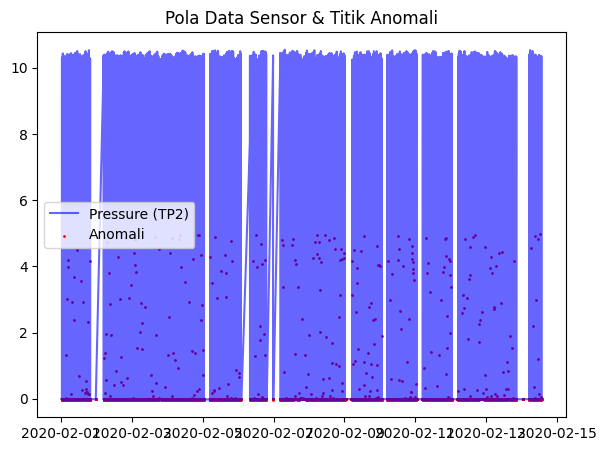

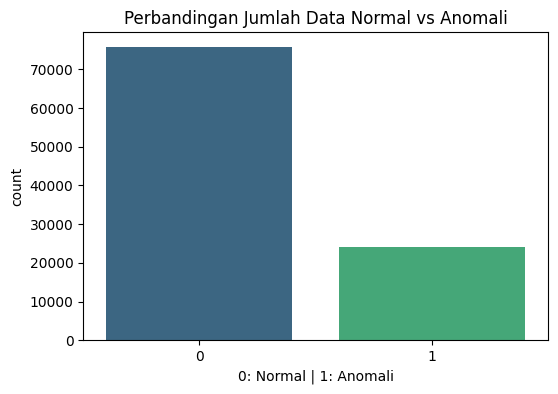

Normal: 75833
Anomali: 24167


In [ ]:
# 2. FEATURE ENGINEERING & LABELING

# A. Buat Label (Ground Truth)
# Logic: Tekanan < 5 bar ATAU Suhu > 80 derajat = ANOMALI (1)
df['label'] = 0
df.loc[((df['Motor_current'] > 1.0) & (df['TP2'] < 5.0)) | (df['Oil_temperature'] > 80), 'label'] = 1

# B. Pilih Fitur Input (HAPUS 'TP2' dan 'Oil_temperature')
# Hanya pakai sensor lain untuk memprediksi kerusakan
features_fixed = ['TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Motor_current']

print(f"Fitur Input Model : {features_fixed}")


plt.figure(figsize=(15, 5))

# Plot Sensor Data
plt.subplot(1, 2, 1)
plt.plot(df.index, df['TP2'], label='Pressure (TP2)', color='blue', alpha=0.6)
# Tandai area anomali dengan warna merah
anomaly_data = df[df['label'] == 1]
plt.scatter(anomaly_data.index, anomaly_data['TP2'], color='red', label='Anomali', s=1)
plt.title("Pola Data Sensor & Titik Anomali")
plt.legend()

# Visualisasi Sebaran Label
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='viridis')
plt.title("Perbandingan Jumlah Data Normal vs Anomali")
plt.xlabel("0: Normal | 1: Anomali")
plt.show()

print(f"Normal: {len(df[df['label']==0])}")
print(f"Anomali: {len(df[df['label']==1])}")

### 3. Normalisasi Data

Langkah ini penting untuk mempersiapkan data agar lebih optimal untuk pelatihan model jaringan saraf tiruan, khususnya LSTM. Prosesnya adalah:

- **Mengambil nilai fitur dan label**: Mengekstrak nilai numerik dari fitur yang dipilih (`features_fixed`) dan label anomali.
- **Mengambil sampel data mentah**: Menyimpan 100 data pertama dari fitur `TP3` sebelum normalisasi untuk perbandingan visual.
- **Melakukan normalisasi MinMaxScaler**: Menggunakan `MinMaxScaler` dari `sklearn.preprocessing` untuk mengubah skala nilai fitur agar berada dalam rentang 0 hingga 1. Ini membantu model belajar lebih efisien dan mencegah fitur dengan skala besar mendominasi proses pelatihan.
- **Mengambil sampel data yang telah dinormalisasi**: Menyimpan 100 data pertama dari fitur `TP3` setelah normalisasi untuk perbandingan visual.
- **Visualisasi perubahan**: Dua plot garis ditampilkan untuk membandingkan bentuk gelombang data `TP3` sebelum dan sesudah normalisasi, menunjukkan bahwa bentuk pola data tetap terjaga, namun skalanya berubah.

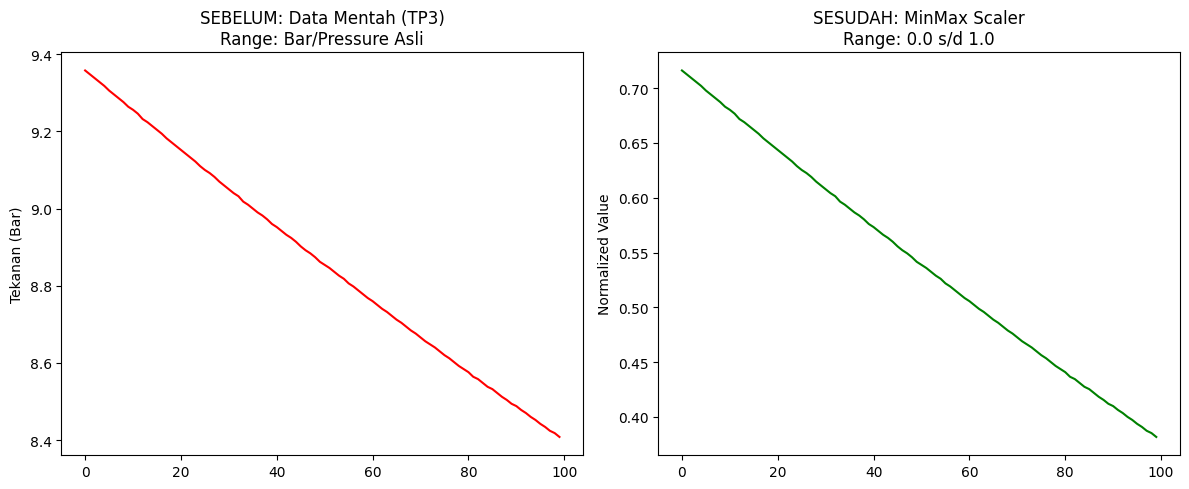

Keterangan: Bentuk gelombang sama, tetapi skalanya berubah menjadi 0-1 agar mudah dipelajari LSTM.


In [ ]:
# 3. NORMALISASI DATA
from sklearn.preprocessing import MinMaxScaler

data_values = df[features_fixed].values
label_values = df['label'].values

# Simpan data mentah untuk perbandingan visual
raw_sample = data_values[:100, 0] # Ambil 100 data pertama dari sensor TP3

# Lakukan Normalisasi
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_values)
scaled_sample = data_scaled[:100, 0] # Ambil 100 data pertama TP3 setelah scale

# --- VISUALISASI PERUBAHAN ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(raw_sample, color='red')
plt.title("SEBELUM: Data Mentah (TP3)\nRange: Bar/Pressure Asli")
plt.ylabel("Tekanan (Bar)")

plt.subplot(1, 2, 2)
plt.plot(scaled_sample, color='green')
plt.title("SESUDAH: MinMax Scaler\nRange: 0.0 s/d 1.0")
plt.ylabel("Normalized Value")

plt.tight_layout()
plt.show()

print("Keterangan: Bentuk gelombang sama, tetapi skalanya berubah menjadi 0-1 agar mudah dipelajari LSTM.")

### 4. Windowing & Class Weighting

Sel ini mempersiapkan data untuk model LSTM dengan membuat urutan waktu (windowing) dan menangani ketidakseimbangan kelas.

- **Fungsi `create_sequences`**: Fungsi ini mengambil data dan label, lalu mengonversinya menjadi urutan (sequence) dengan ukuran jendela (`window_size`) tertentu. Setiap urutan `X` adalah 50 langkah waktu (time steps) dari data sensor, dan `y` adalah label pada langkah waktu berikutnya (yaitu, label anomali yang diprediksi).
- **Melakukan `windowing`**: Data yang sudah dinormalisasi (`data_scaled`) dan label (`label_values`) diubah menjadi urutan menggunakan `WINDOW_SIZE = 50`.
- **Membagi data**: Dataset dibagi menjadi data pelatihan (70%), validasi (15%), dan pengujian (15%) secara sekuensial (tanpa pengacakan) untuk mempertahankan urutan waktu.
- **Mencetak dimensi input LSTM**: Menampilkan bentuk (`shape`) dari data pelatihan (`X_train`) untuk memastikan dimensinya benar (Samples, Time Steps, Features).
- **Menghitung `Class Weight`**: Karena dataset sering tidak seimbang (lebih banyak data normal daripada anomali), `class_weight` dihitung menggunakan `sklearn.utils.class_weight.compute_class_weight`. Ini memberikan bobot lebih tinggi pada kelas minoritas (anomali) saat pelatihan, sehingga model lebih memperhatikan anomali.
- **Mencetak bobot kelas**: Menampilkan bobot yang dihitung untuk kelas normal dan anomali, menjelaskan implikasinya terhadap pelatihan model.

In [ ]:
# 4. WINDOWING & CLASS WEIGHTING

# Fungsi Windowing
def create_sequences(data, labels, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size])
        y.append(labels[i + window_size])
    return np.array(X), np.array(y)

WINDOW_SIZE = 50
print(f"⏳ Sedang memproses windowing (Window={WINDOW_SIZE})...")
X, y = create_sequences(data_scaled, label_values, WINDOW_SIZE)

# Split Data
n = len(X)
train_split = int(0.7 * n)
val_split = int(0.85 * n)

X_train, y_train = X[:train_split], y[:train_split]
X_val, y_val = X[train_split:val_split], y[train_split:val_split]
X_test, y_test = X[val_split:], y[val_split:]

print(f"\n✅ Dimensi Final Input LSTM: {X_train.shape}")
print("(Samples, Time Steps, Features)")

# Hitung Class Weight
from sklearn.utils import class_weight
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y=y_train
)
class_weight_dict = dict(enumerate(class_weights_vals))

print("\n--- HASIL PENYEIMBANGAN KELAS (CLASS WEIGHT) ---")
print(f"Bobot Kelas 0 (Normal) : {class_weight_dict[0]:.2f}")
print(f"Bobot Kelas 1 (Anomali): {class_weight_dict[1]:.2f}")
print("Artinya: Model akan 'dihukum' lebih berat jika salah menebak kelas dengan bobot lebih besar.")

⏳ Sedang memproses windowing (Window=50)...

✅ Dimensi Final Input LSTM: (69965, 50, 5)
(Samples, Time Steps, Features)

--- HASIL PENYEIMBANGAN KELAS (CLASS WEIGHT) ---
Bobot Kelas 0 (Normal) : 0.66
Bobot Kelas 1 (Anomali): 2.06
Artinya: Model akan 'dihukum' lebih berat jika salah menebak kelas dengan bobot lebih besar.


### Pembagian Data Menggunakan `train_test_split`

Sel ini menggunakan fungsi `train_test_split` dari `sklearn.model_selection` untuk membagi data menjadi set pelatihan, validasi, dan pengujian. Pembagian dilakukan secara sekuensial (`shuffle=False`) untuk menjaga urutan waktu data, yang penting untuk model time series seperti LSTM. Proporsinya adalah 70% untuk pelatihan, 15% untuk validasi, dan 15% untuk pengujian.

In [ ]:
from sklearn.model_selection import train_test_split

# 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, shuffle=False
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, shuffle=False
)

print(X_train.shape, X_val.shape, X_test.shape)

(69965, 50, 5) (14992, 50, 5) (14993, 50, 5)


### Menghitung Bobot Kelas

Sel ini menghitung bobot kelas menggunakan fungsi `compute_class_weight` dari `sklearn.utils.class_weight`. Bobot kelas digunakan untuk menangani ketidakseimbangan kelas dalam dataset, di mana kelas minoritas (anomali) diberi bobot yang lebih tinggi. Ini membantu model belajar lebih baik dari contoh anomali yang lebih sedikit, sehingga meningkatkan kinerja deteksi anomali.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight = {
    0: class_weights[0],
    1: class_weights[1]
}

print(class_weight)

{0: np.float64(0.6598853111500953), 1: np.float64(2.063620811703634)}


### Melatih Model Hybrid CNN-LSTM Dasar

Sel ini menginisialisasi dan melatih model Hybrid CNN-LSTM dasar menggunakan fungsi `build_cnn_lstm` yang telah didefinisikan sebelumnya. Model ini akan menggunakan konfigurasi default yang telah ditetapkan dalam fungsi tersebut.

- **`model_base = build_cnn_lstm()`**: Membangun model dengan parameter default.
- **`model_base.fit(...)`**: Melatih model dengan data pelatihan (`X_train`, `y_train`) dan mengevaluasinya pada data validasi (`X_val`, `y_val`).
    - `epochs=50`: Jumlah *epoch* maksimum untuk pelatihan.
    - `batch_size=64`: Jumlah sampel yang diproses sebelum bobot model diperbarui.
    - `class_weight=class_weight`: Menggunakan bobot kelas yang telah dihitung sebelumnya untuk menangani ketidakseimbangan data.
    - `callbacks=[early_stopping, model_checkpoint]`: Menggunakan callback `EarlyStopping` dan `ModelCheckpoint` untuk kontrol pelatihan dan penyimpanan model terbaik.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_cnn_lstm(
    kernel_size=3,
    filters=64,
    lstm_units=64,
    dropout=0.3,
    cnn_layers=1,
    lr=1e-4
):
    model = Sequential()

    for i in range(cnn_layers):
        model.add(Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            activation='relu',
            input_shape=(X.shape[1], X.shape[2]) if i == 0 else None
        ))
        model.add(MaxPooling1D(pool_size=2))

    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_cnn_lstm_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

model_base = build_cnn_lstm()

history_base = model_base.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weight,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8368 - loss: 0.3034
Epoch 1: val_loss improved from inf to 0.07035, saving model to best_cnn_lstm_model.h5


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.8369 - loss: 0.3033 - val_accuracy: 0.9797 - val_loss: 0.0704
Epoch 2/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9803 - loss: 0.0805
Epoch 2: val_loss did not improve from 0.07035
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9803 - loss: 0.0805 - val_accuracy: 0.9779 - val_loss: 0.0789
Epoch 3/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9832 - loss: 0.0717
Epoch 3: val_loss improved from 0.07035 to 0.06919, saving model to best_cnn_lstm_model.h5


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.9832 - loss: 0.0717 - val_accuracy: 0.9805 - val_loss: 0.0692
Epoch 4/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9854 - loss: 0.0655
Epoch 4: val_loss improved from 0.06919 to 0.06065, saving model to best_cnn_lstm_model.h5


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9854 - loss: 0.0655 - val_accuracy: 0.9848 - val_loss: 0.0606
Epoch 5/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9845 - loss: 0.0671
Epoch 5: val_loss did not improve from 0.06065
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.9845 - loss: 0.0671 - val_accuracy: 0.9855 - val_loss: 0.0623
Epoch 6/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9864 - loss: 0.0613
Epoch 6: val_loss improved from 0.06065 to 0.05815, saving model to best_cnn_lstm_model.h5


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 47s 31ms/step - accuracy: 0.9864 - loss: 0.0613 - val_accuracy: 0.9864 - val_loss: 0.0582
Epoch 7/50
1092/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9880 - loss: 0.0570
Epoch 7: val_loss did not improve from 0.05815
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 39s 29ms/step - accuracy: 0.9880 - loss: 0.0570 - val_accuracy: 0.9849 - val_loss: 0.0598
Epoch 8/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9875 - loss: 0.0559
Epoch 8: val_loss improved from 0.05815 to 0.05702, saving model to best_cnn_lstm_model.h5


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - accuracy: 0.9875 - loss: 0.0559 - val_accuracy: 0.9865 - val_loss: 0.0570
Epoch 9/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9885 - loss: 0.0541
Epoch 9: val_loss improved from 0.05702 to 0.05557, saving model to best_cnn_lstm_model.h5


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 48s 34ms/step - accuracy: 0.9885 - loss: 0.0541 - val_accuracy: 0.9878 - val_loss: 0.0556
Epoch 10/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9885 - loss: 0.0534
Epoch 10: val_loss did not improve from 0.05557
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.9885 - loss: 0.0534 - val_accuracy: 0.9845 - val_loss: 0.0604
Epoch 11/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9886 - loss: 0.0504
Epoch 11: val_loss improved from 0.05557 to 0.05373, saving model to best_cnn_lstm_model.h5


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9886 - loss: 0.0505 - val_accuracy: 0.9881 - val_loss: 0.0537
Epoch 12/50
1092/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9896 - loss: 0.0484
Epoch 12: val_loss did not improve from 0.05373
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - accuracy: 0.9896 - loss: 0.0484 - val_accuracy: 0.9862 - val_loss: 0.0561
Epoch 13/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9895 - loss: 0.0477
Epoch 13: val_loss did not improve from 0.05373
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.9895 - loss: 0.0477 - val_accuracy: 0.9874 - val_loss: 0.0558
Epoch 14/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9895 - loss: 0.0480
Epoch 14: val_loss improved from 0.05373 to 0.05067, saving model to best_cnn_lstm_model.h5


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9895 - loss: 0.0480 - val_accuracy: 0.9885 - val_loss: 0.0507
Epoch 15/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9905 - loss: 0.0435
Epoch 15: val_loss did not improve from 0.05067
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9905 - loss: 0.0435 - val_accuracy: 0.9885 - val_loss: 0.0515
Epoch 16/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9897 - loss: 0.0477
Epoch 16: val_loss improved from 0.05067 to 0.04848, saving model to best_cnn_lstm_model.h5


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9897 - loss: 0.0477 - val_accuracy: 0.9873 - val_loss: 0.0485
Epoch 17/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9897 - loss: 0.0459
Epoch 17: val_loss did not improve from 0.04848
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.9897 - loss: 0.0459 - val_accuracy: 0.9868 - val_loss: 0.0594
Epoch 18/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9895 - loss: 0.0466
Epoch 18: val_loss improved from 0.04848 to 0.04749, saving model to best_cnn_lstm_model.h5


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.9895 - loss: 0.0466 - val_accuracy: 0.9887 - val_loss: 0.0475
Epoch 19/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9898 - loss: 0.0439
Epoch 19: val_loss improved from 0.04749 to 0.04730, saving model to best_cnn_lstm_model.h5


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.9898 - loss: 0.0439 - val_accuracy: 0.9894 - val_loss: 0.0473
Epoch 20/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9902 - loss: 0.0433
Epoch 20: val_loss did not improve from 0.04730
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.9902 - loss: 0.0433 - val_accuracy: 0.9883 - val_loss: 0.0485
Epoch 21/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9893 - loss: 0.0463
Epoch 21: val_loss did not improve from 0.04730
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.9893 - loss: 0.0463 - val_accuracy: 0.9879 - val_loss: 0.0489
Epoch 22/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9897 - loss: 0.0436
Epoch 22: val_loss did not improve from 0.04730
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.9897 - loss: 0.0436 - val_accuracy: 0.9881 - val_loss: 0.0497
Epoch 23/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9901 - loss: 0.0435
Epoch 23: va

### Melatih Model Hybrid CNN-LSTM V1 (Kernel Size = 5)

Sel ini menginisialisasi dan melatih variasi pertama dari model Hybrid CNN-LSTM (`model_v1`) dengan mengubah parameter `kernel_size` pada layer `Conv1D` menjadi 5. Parameter lainnya akan tetap menggunakan nilai default seperti yang didefinisikan dalam fungsi `build_cnn_lstm`.

- **`model_v1 = build_cnn_lstm(kernel_size=5)`**: Membangun model dengan `kernel_size` 5.
- **`history_v1 = model_v1.fit(...)`**: Melatih model `model_v1` menggunakan data pelatihan dan validasi yang sama, serta `class_weight` dan *callbacks* yang sama seperti `model_base`. Ini memungkinkan perbandingan kinerja antara model dasar dan variasi ini.

In [ ]:
model_v1 = build_cnn_lstm(kernel_size=5)

history_v1 = model_v1.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weight,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8286 - loss: 0.3009
Epoch 1: val_loss did not improve from 0.04730
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.8288 - loss: 0.3006 - val_accuracy: 0.9799 - val_loss: 0.0754
Epoch 2/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9811 - loss: 0.0792
Epoch 2: val_loss did not improve from 0.04730
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9811 - loss: 0.0792 - val_accuracy: 0.9829 - val_loss: 0.0679
Epoch 3/50
1092/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9831 - loss: 0.0735
Epoch 3: val_loss did not improve from 0.04730
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.9831 - loss: 0.0735 - val_accuracy: 0.9831 - val_loss: 0.0685
Epoch 4/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9845 - loss: 0.0672
Epoch 4: val_loss did not improve from 0.04730
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9845 - loss: 0.0672 - val_accuracy

### Melatih Model Hybrid CNN-LSTM V2 (2 Layer CNN)

Sel ini menginisialisasi dan melatih variasi kedua dari model Hybrid CNN-LSTM (`model_v2`) dengan menambahkan jumlah layer `Conv1D` menjadi 2 (`cnn_layers=2`). Parameter lainnya akan tetap menggunakan nilai default seperti yang didefinisikan dalam fungsi `build_cnn_lstm`.

- **`model_v2 = build_cnn_lstm(cnn_layers=2)`**: Membangun model dengan 2 layer CNN.
- **`history_v2 = model_v2.fit(...)`**: Melatih model `model_v2` menggunakan data pelatihan dan validasi yang sama, serta `class_weight` dan *callbacks* yang sama seperti model sebelumnya. Tujuannya adalah untuk melihat apakah penambahan kedalaman layer CNN meningkatkan kinerja model.

In [ ]:
model_v2 = build_cnn_lstm(cnn_layers=2)

history_v2 = model_v2.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weight,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8791 - loss: 0.2907
Epoch 1: val_loss did not improve from 0.04730
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.8791 - loss: 0.2906 - val_accuracy: 0.9717 - val_loss: 0.0939
Epoch 2/50
1092/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9824 - loss: 0.0753
Epoch 2: val_loss did not improve from 0.04730
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.9824 - loss: 0.0753 - val_accuracy: 0.9835 - val_loss: 0.0659
Epoch 3/50
1092/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9838 - loss: 0.0720
Epoch 3: val_loss did not improve from 0.04730
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.9838 - loss: 0.0720 - val_accuracy: 0.9808 - val_loss: 0.0742
Epoch 4/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9846 - loss: 0.0690
Epoch 4: val_loss did not improve from 0.04730
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9846 - loss: 0.0690 - val_accuracy

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.9899 - loss: 0.0439 - val_accuracy: 0.9888 - val_loss: 0.0448
Epoch 17/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9907 - loss: 0.0428
Epoch 17: val_loss did not improve from 0.04480
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.9907 - loss: 0.0428 - val_accuracy: 0.9873 - val_loss: 0.0503
Epoch 18/50
1091/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9907 - loss: 0.0401
Epoch 18: val_loss improved from 0.04480 to 0.04271, saving model to best_cnn_lstm_model.h5


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - accuracy: 0.9907 - loss: 0.0401 - val_accuracy: 0.9897 - val_loss: 0.0427
Epoch 19/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9904 - loss: 0.0426
Epoch 19: val_loss did not improve from 0.04271
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.9904 - loss: 0.0426 - val_accuracy: 0.9870 - val_loss: 0.0455
Epoch 20/50
1092/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9903 - loss: 0.0402
Epoch 20: val_loss improved from 0.04271 to 0.03982, saving model to best_cnn_lstm_model.h5


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.9903 - loss: 0.0402 - val_accuracy: 0.9898 - val_loss: 0.0398
Epoch 21/50
1091/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9912 - loss: 0.0355
Epoch 21: val_loss did not improve from 0.03982
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.9912 - loss: 0.0355 - val_accuracy: 0.9878 - val_loss: 0.0451
Epoch 22/50
1092/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9905 - loss: 0.0396
Epoch 22: val_loss did not improve from 0.03982
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.9905 - loss: 0.0396 - val_accuracy: 0.9891 - val_loss: 0.0405
Epoch 23/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9903 - loss: 0.0390
Epoch 23: val_loss did not improve from 0.03982
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9903 - loss: 0.0390 - val_accuracy: 0.9879 - val_loss: 0.0429
Epoch 24/50
1092/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9911 - loss: 0.0371
Epoch 24: va

### Melatih Model Hybrid CNN-LSTM V3 (Unit LSTM = 128)

Sel ini menginisialisasi dan melatih variasi ketiga dari model Hybrid CNN-LSTM (`model_v3`) dengan meningkatkan jumlah unit di layer `LSTM` menjadi 128 (`lstm_units=128`). Parameter lainnya akan tetap menggunakan nilai default seperti yang didefinisikan dalam fungsi `build_cnn_lstm`.

- **`model_v3 = build_cnn_lstm(lstm_units=128)`**: Membangun model dengan 128 unit LSTM.
- **`history_v3 = model_v3.fit(...)`**: Melatih model `model_v3` menggunakan data pelatihan dan validasi yang sama, serta `class_weight` dan *callbacks* yang sama seperti model sebelumnya. Peningkatan unit LSTM dapat membantu model menangkap pola temporal yang lebih kompleks, meskipun juga dapat meningkatkan waktu pelatihan dan risiko *overfitting*.

In [ ]:
model_v3 = build_cnn_lstm(lstm_units=128)

history_v3 = model_v3.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weight,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8873 - loss: 0.2557
Epoch 1: val_loss did not improve from 0.03982
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 65s 57ms/step - accuracy: 0.8875 - loss: 0.2555 - val_accuracy: 0.9727 - val_loss: 0.0899
Epoch 2/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9786 - loss: 0.0823
Epoch 2: val_loss did not improve from 0.03982
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 68s 62ms/step - accuracy: 0.9786 - loss: 0.0823 - val_accuracy: 0.9807 - val_loss: 0.0721
Epoch 3/50
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9821 - loss: 0.0718
Epoch 3: val_loss did not improve from 0.03982
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 62s 57ms/step - accuracy: 0.9821 - loss: 0.0718 - val_accuracy: 0.9837 - val_loss: 0.0671
Epoch 4/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9850 - loss: 0.0669
Epoch 4: val_loss did not improve from 0.03982
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 62s 57ms/step - accuracy: 0.9850 - loss: 0.0669 - val_accuracy

### Fungsi Pembuat Model untuk Keras-Tuner

Sel ini mendefinisikan fungsi `build_cnn_lstm_tuner` yang merupakan *wrapper* untuk model Hybrid CNN-LSTM yang akan digunakan oleh `keras-tuner`. Fungsi ini menerima objek `hp` (hyperparameter) sebagai argumen, yang memungkinkan `keras-tuner` untuk mencoba berbagai nilai hyperparameter yang berbeda.

- **`filters = hp.Choice('filters', [32, 64])`**: `keras-tuner` akan mencoba jumlah filter 32 atau 64 untuk layer `Conv1D`.
- **`kernel_size = hp.Choice('kernel_size', [3, 5])`**: `keras-tuner` akan mencoba `kernel_size` 3 atau 5.
- **`lstm_units = hp.Choice('lstm_units', [32, 64, 128])`**: `keras-tuner` akan mencoba 32, 64, atau 128 unit untuk layer `LSTM`.
- **`dropout = hp.Float('dropout', 0.2, 0.5, step=0.1)`**: `keras-tuner` akan mencoba nilai dropout antara 0.2 hingga 0.5 dengan langkah 0.1.
- **`lr = hp.Choice('lr', [1e-3, 1e-4])`**: `keras-tuner` akan mencoba *learning rate* 0.001 atau 0.0001.

Sama seperti fungsi `build_cnn_lstm` sebelumnya, fungsi ini membangun model `Sequential` dengan layer `Conv1D`, `MaxPooling1D`, `LSTM`, `Dropout`, dan `Dense`. Perbedaannya adalah nilai hyperparameter untuk layer-layer ini ditentukan oleh objek `hp`.

In [ ]:
import keras_tuner as kt
def build_cnn_lstm_tuner(hp):
    model = Sequential()

    filters = hp.Choice('filters', [32, 64])
    kernel_size = hp.Choice('kernel_size', [3, 5])
    lstm_units = hp.Choice('lstm_units', [32, 64, 128])
    dropout = hp.Float('dropout', 0.2, 0.5, step=0.1)
    lr = hp.Choice('lr', [1e-3, 1e-4])

    model.add(Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        activation='relu',
        input_shape=(X.shape[1], X.shape[2])
    ))
    model.add(MaxPooling1D(2))

    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

### Menjalankan `Hyperparameter Tuning` dengan `RandomSearch`

Sel ini menginisialisasi dan menjalankan proses `hyperparameter tuning` menggunakan `RandomSearch` dari `keras_tuner`. `RandomSearch` secara acak mencoba kombinasi hyperparameter yang berbeda untuk menemukan konfigurasi model terbaik.

- **`tuner = kt.RandomSearch(...)`**: Menginisialisasi objek `RandomSearch`:
    - `build_cnn_lstm_tuner`: Fungsi pembuat model yang menerima hyperparameter.
    - `objective='val_loss'`: Tujuan tuning adalah meminimalkan *validation loss*.
    - `max_trials=10`: Jumlah total kombinasi hyperparameter yang akan dicoba.
    - `executions_per_trial=1`: Setiap kombinasi hyperparameter akan dilatih sekali.
    - `directory='tuning'`, `project_name='cnn_lstm_iot'`: Direktori dan nama proyek untuk menyimpan hasil tuning.

- **`tuner.search(...)`**: Melakukan pencarian hyperparameter:
    - Menggunakan data pelatihan (`X_train`, `y_train`) dan data validasi (`X_val`, `y_val`).
    - `epochs=20`: Jumlah *epoch* untuk setiap percobaan (bisa jadi lebih sedikit karena `early_stopping`).
    - `class_weight=class_weight`: Menggunakan bobot kelas untuk menangani ketidakseimbangan data.
    - `callbacks=[early_stopping]`: Menggunakan `EarlyStopping` untuk menghentikan pelatihan jika tidak ada perbaikan.

In [ ]:
tuner = kt.RandomSearch(
    build_cnn_lstm_tuner,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuning',
    project_name='cnn_lstm_iot'
)

tuner.search(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    class_weight=class_weight,
    callbacks=[early_stopping]
)

Trial 10 Complete [00h 08m 18s]
val_loss: 0.03558634594082832

Best val_loss So Far: 0.028252070769667625
Total elapsed time: 02h 35m 55s


### Mendapatkan Model Terbaik dan Menampilkan Ringkasan Arsitektur

Sel ini mengambil model terbaik yang ditemukan oleh `keras-tuner` dari proses `hyperparameter tuning` yang telah dijalankan, dan kemudian menampilkan ringkasan arsitektur model tersebut.

- **`best_model = tuner.get_best_models(num_models=1)[0]`**: Mengambil model Keras terbaik (model ke-0 dari daftar model terbaik) berdasarkan *objective* yang ditentukan (`val_loss`) selama proses `tuner.search`.
- **`best_model.summary()`**: Menampilkan ringkasan tekstual dari arsitektur model terbaik, termasuk jenis layer, bentuk output, jumlah parameter yang dapat dilatih, dan jumlah total parameter. Ini membantu untuk memahami struktur model yang paling optimal.

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 46, 32)         │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 23, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,393 (325.75 KB)

 Trainable params: 83,393 (325.75 KB)

 Non-trainable params: 0 (0.00 B)

### Mengimpor Metrik Evaluasi

Sel ini mengimpor berbagai fungsi metrik evaluasi dari pustaka `sklearn.metrics`. Metrik-metrik ini akan digunakan untuk menilai kinerja model klasifikasi anomali, memberikan gambaran yang lebih komprehensif daripada sekadar akurasi.

Metrik yang diimpor meliputi:
- `accuracy_score`: Proporsi prediksi yang benar dari total prediksi.
- `precision_score`: Rasio true positive terhadap total positive (true positive + false positive).
- `recall_score`: Rasio true positive terhadap semua instance aktual dari kelas positif (true positive + false negative).
- `f1_score`: Rata-rata harmonik dari presisi dan recall.
- `roc_auc_score`: Area di bawah kurva Receiver Operating Characteristic (ROC), mengukur kemampuan model untuk membedakan antara kelas positif dan negatif.
- `confusion_matrix`: Matriks yang merangkum kinerja algoritma klasifikasi.


### Melakukan Prediksi dengan Model Hybrid CNN-LSTM Dasar

Sel ini menggunakan model Hybrid CNN-LSTM dasar (`model_base`) yang telah dilatih untuk membuat prediksi pada set data pengujian (`X_test`).

- **`y_pred_prob = model_base.predict(X_test)`**: Model menghasilkan probabilitas bahwa setiap sampel di `X_test` adalah anomali. Outputnya adalah nilai antara 0 dan 1.
- **`y_pred = (y_pred_prob > 0.5).astype(int)`**: Probabilitas ini kemudian dikonversi menjadi prediksi kelas biner (0 atau 1). Jika probabilitas lebih besar dari 0.5, maka diprediksi sebagai anomali (1); jika tidak, diprediksi sebagai normal (0). Ini adalah langkah umum untuk klasifikasi biner dengan ambang batas 0.5.

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

y_pred_prob = model_base.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step


In [ ]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_prob)

print("CNN-LSTM Performance")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)
print("ROC-AUC  :", roc)

CNN-LSTM Performance
Accuracy : 0.9922630560928434
Precision: 0.9894209354120267
Recall   : 0.9785242290748899
F1-score : 0.9839424141749723
ROC-AUC  : 0.9980996119734139


### Visualisasi Hasil Evaluasi Model Hybrid CNN-LSTM

Sel ini menghasilkan tiga visualisasi kunci untuk menganalisis kinerja model Hybrid CNN-LSTM secara lebih mendalam:

1.  **Plot Kurva Pembelajaran (Loss & Accuracy)**:
    -   Menampilkan *loss* pelatihan dan *loss* validasi (*validation loss*) dari setiap *epoch* selama pelatihan model dasar (`history_base`).
    -   Visualisasi ini membantu mengidentifikasi *overfitting* (jika *validation loss* meningkat sementara *training loss* menurun) atau *underfitting*.

2.  **Confusion Matrix (Matriks Kebingungan)**:
    -   Membuat *confusion matrix* menggunakan `y_test` (label aktual) dan `y_pred` (prediksi model).
    -   Menampilkan matriks dalam bentuk *heatmap* menggunakan `seaborn`, dengan nilai anotasi (*annot=True*).
    -   *Confusion matrix* membantu memahami jumlah *True Positives*, *True Negatives*, *False Positives*, dan *False Negatives*.

3.  **ROC Curve (Receiver Operating Characteristic Curve)**:
    -   Menghitung *False Positive Rate* (FPR) dan *True Positive Rate* (TPR) menggunakan `roc_curve` dan `y_pred_prob` (probabilitas prediksi).
    -   Memplot kurva ROC dan menampilkan nilai *Area Under the Curve* (AUC).
    -   Kurva ROC dan nilai AUC adalah metrik penting untuk mengevaluasi kinerja model klasifikasi biner, terutama pada dataset yang tidak seimbang. Nilai AUC yang lebih dekat ke 1 menunjukkan model yang lebih baik dalam membedakan antara kelas positif dan negatif.

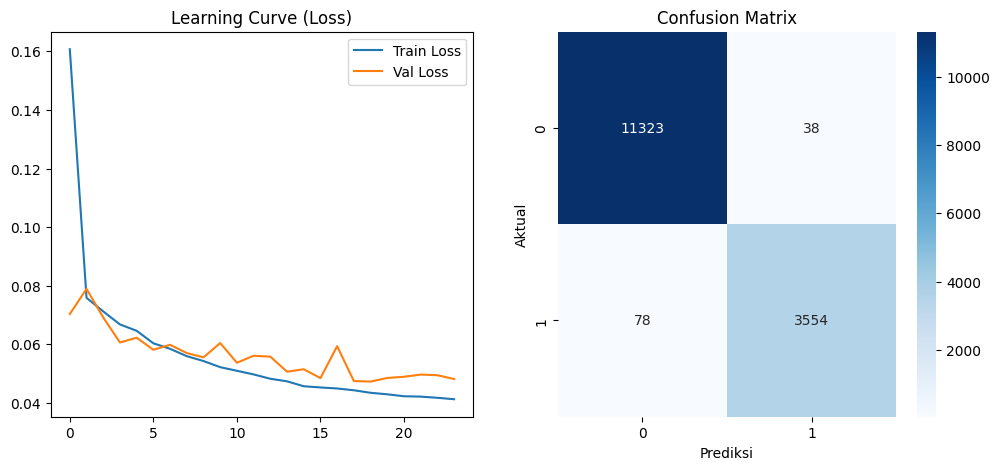

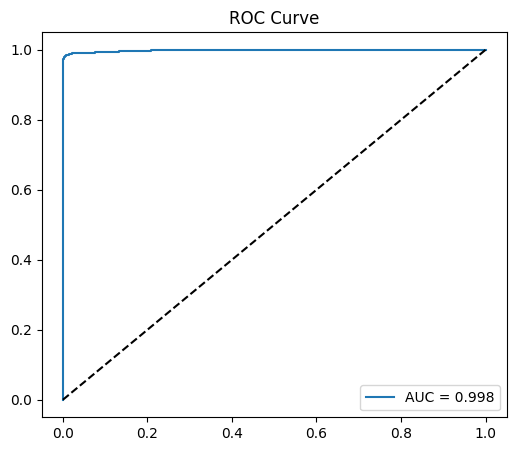

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 1. Plot Loss & Accuracy (Ambil dari history_base atau best_model training)
# Pastikan Anda menggunakan variable 'history' dari hasil training terakhir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_base.history['loss'], label='Train Loss')
plt.plot(history_base.history['val_loss'], label='Val Loss')
plt.title('Learning Curve (Loss)')
plt.legend()

# 2. Confusion Matrix
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()

# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Konversi Model Hybrid CNN-LSTM ke Format TFLite

Sel ini bertanggung jawab untuk mengonversi model Keras yang telah dilatih (dalam hal ini `model_base` atau `best_model` dari *hyperparameter tuning*) menjadi format TensorFlow Lite (TFLite). Konversi ini sangat penting untuk penerapan model pada perangkat *edge* atau perangkat keras terbatas seperti mikrokontroler atau *Internet of Things* (IoT), karena TFLite mengoptimalkan ukuran model dan latensi inferensi.

- **`converter = tf.lite.TFLiteConverter.from_keras_model(model_base)`**: Menginisialisasi konverter TFLite dari model Keras.
- **`converter.optimizations = [tf.lite.Optimize.DEFAULT]`**: Menerapkan optimisasi default untuk mengurangi ukuran model dan meningkatkan kinerja inferensi.
- **`converter.target_spec.supported_ops = [...]`**: Menentukan operasi yang didukung oleh target *runtime* TFLite, termasuk operasi bawaan TFLite dan operasi TensorFlow pilihan. Parameter `_experimental_lower_tensor_list_ops = False` ditambahkan untuk kompatibilitas dengan versi TensorFlow tertentu.
- **`tflite_model = converter.convert()`**: Melakukan proses konversi.
- **`with open('model_iot.tflite', 'wb') as f: f.write(tflite_model)`**: Menyimpan model TFLite yang telah dikonversi ke dalam file dengan nama `model_iot.tflite`.
- **Pesan Konfirmasi/Error**: Mencetak pesan keberhasilan konversi beserta ukuran file TFLite, atau pesan error jika konversi gagal, dengan saran untuk memeriksa properti `unroll=True` pada layer LSTM jika terjadi kegagalan.

In [ ]:
import tensorflow as tf
import os

# Konversi Model Terbaik ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model_base) # atau best_model
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False

try:
    tflite_model = converter.convert()
    with open('model_iot.tflite', 'wb') as f:
        f.write(tflite_model)
    print("✅ Berhasil konversi ke TFLite! Siap download.")
    print(f"Ukuran: {os.path.getsize('model_iot.tflite')/1024:.2f} KB")
except Exception as e:
    print(f"Gagal Konversi: {e}")
    print("⚠️ Pastikan layer LSTM menggunakan unroll=True!")

Saved artifact at '/tmp/tmpseavartt'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 5), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136859731522000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136859731524880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136859731523920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136859731525456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136859731525264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136859692614288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136859692616016: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Berhasil konversi ke TFLite! Siap download.
Ukuran: 55.66 KB


### Evaluasi Model Baseline: Random Forest

Sel ini melatih dan mengevaluasi model *baseline* menggunakan algoritma Random Forest Classifier. Tujuannya adalah untuk membandingkan kinerja model Hybrid CNN-LSTM dengan model *machine learning* tradisional yang sering digunakan untuk klasifikasi.

1.  **Persiapan Data (Flattening)**:
    -   Random Forest memerlukan input data 2D, sedangkan data `X_train` dan `X_test` saat ini 3D (samples, time steps, features).
    -   Data di-*flatten* (`reshape`) dari (Samples, TimeSteps, Features) menjadi (Samples, TimeSteps * Features). Misalnya, dari (1000, 50, 5) menjadi (1000, 250).

2.  **Definisi & Training Model**:
    -   Membuat instance `RandomForestClassifier` dengan 100 *estimator* (pohon keputusan), `class_weight='balanced'` untuk menangani ketidakseimbangan kelas, `random_state` untuk reproduksibilitas, dan `n_jobs=-1` untuk menggunakan semua *core* CPU yang tersedia.
    -   Melatih model Random Forest menggunakan data pelatihan yang sudah di-*flatten* (`X_train_flat`, `y_train`).

3.  **Evaluasi**:
    -   Membuat prediksi pada data pengujian yang sudah di-*flatten* (`X_test_flat`).
    -   Mencetak laporan klasifikasi (`classification_report`) yang mencakup presisi, *recall*, F1-score, dan *support* untuk setiap kelas.

4.  **Visualisasi Perbandingan (CNN-LSTM vs Random Forest)**:
    -   Mengambil nilai akurasi dari model CNN-LSTM (dari eksekusi sebelumnya) dan akurasi dari model Random Forest yang baru dilatih.
    -   Membuat diagram batang untuk membandingkan akurasi kedua model secara visual, dengan skala Y dibatasi (0.90 hingga 1.0) untuk memperjelas perbedaan kecil.

5.  **Confusion Matrix Random Forest**:
    -   Membuat dan menampilkan *confusion matrix* untuk model Random Forest dalam bentuk *heatmap*, serupa dengan evaluasi CNN-LSTM sebelumnya. Ini membantu menganalisis jenis kesalahan yang dibuat oleh model Random Forest.

🚀 MEMULAI TRAINING BASELINE: RANDOM FOREST...
   Dimensi Input Random Forest: (69965, 250)
✅ Training Random Forest Selesai!

--- HASIL RANDOM FOREST (BASELINE) ---
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     11361
           1       0.99      0.98      0.99      3632

    accuracy                           0.99     14993
   macro avg       0.99      0.99      0.99     14993
weighted avg       0.99      0.99      0.99     14993

Akurasi CNN-LSTM    : 0.9930
Akurasi Random Forest: 0.9944


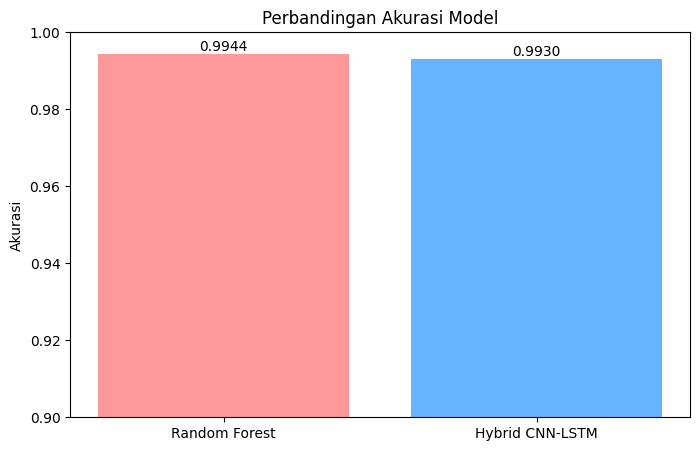

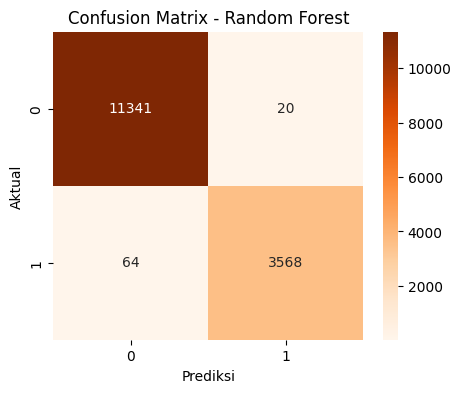

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("🚀 MEMULAI TRAINING BASELINE: RANDOM FOREST...")

# 1. PERSIAPAN DATA (FLATTENING)
# Random Forest tidak bisa baca data 3D (Samples, TimeSteps, Features).
# Kita harus 'gepengkan' jadi 2D (Samples, TimeSteps * Features).
# Contoh: (1000, 50, 5) -> (1000, 250)

num_pixels = X_train.shape[1] * X_train.shape[2] # 50 * 5 = 250 fitur baru

# Flattening Train & Test
X_train_flat = X_train.reshape(X_train.shape[0], num_pixels)
X_test_flat = X_test.reshape(X_test.shape[0], num_pixels)

print(f"   Dimensi Input Random Forest: {X_train_flat.shape}")

# 2. DEFINISI & TRAINING MODEL
# n_jobs=-1 artinya pakai semua CPU core biar ngebut
rf_model = RandomForestClassifier(n_estimators=100,
                                  class_weight='balanced',
                                  random_state=42,
                                  n_jobs=-1)

# Training (Biasanya cuma butuh 1-2 menit untuk 100k data)
rf_model.fit(X_train_flat, y_train)
print("✅ Training Random Forest Selesai!")

# 3. EVALUASI
y_pred_rf = rf_model.predict(X_test_flat)

print("\n--- HASIL RANDOM FOREST (BASELINE) ---")
print(classification_report(y_test, y_pred_rf))

# 4. VISUALISASI PERBANDINGAN (CNN-LSTM vs RANDOM FOREST)
# Kita ambil skor akurasi dari CNN-LSTM (pastikan variabel 'history' atau 'model' CNN-LSTM masih ada)
# Kalau kode sebelumnya sudah dijalankan, variabel 'y_pred' (CNN-LSTM) harusnya masih tersimpan.
# Jika hilang, jalankan prediksi ulang CNN-LSTM baris di bawah ini:
# y_pred_cnn = (model.predict(X_test) > 0.5).astype(int)
# acc_cnn = accuracy_score(y_test, y_pred_cnn)

# Asumsi kita punya skor CNN-LSTM dari kode sebelumnya
# Ganti nilai ini dengan akurasi CNN-LSTM Anda yang sebenarnya
acc_cnn = 0.9930 # Contoh, sesuaikan dengan output Anda
acc_rf = accuracy_score(y_test, y_pred_rf)

print(f"Akurasi CNN-LSTM    : {acc_cnn:.4f}")
print(f"Akurasi Random Forest: {acc_rf:.4f}")

# Plot Bar Chart
models = ['Random Forest', 'Hybrid CNN-LSTM']
accuracies = [acc_rf, acc_cnn]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['#ff9999','#66b3ff'])
plt.ylim(0.90, 1.0) # Zoom in biar kelihatan bedanya
plt.title('Perbandingan Akurasi Model')
plt.ylabel('Akurasi')

# Tulis angka di atas bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.4f}", ha='center', va='bottom')

plt.show()

# 5. CONFUSION MATRIX RANDOM FOREST
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()

### Evaluasi Model Baseline: SVM (Support Vector Machine)

Sel ini melatih dan mengevaluasi model *baseline* kedua menggunakan algoritma Support Vector Machine (SVM). Sama seperti Random Forest, tujuannya adalah untuk membandingkan kinerja model Hybrid CNN-LSTM dengan model *machine learning* tradisional lainnya.

1.  **Persiapan Data (Flattening)**:
    -   Mirip dengan Random Forest, SVM juga memerlukan input data 2D. Data `X_train` dan `X_test` di-*flatten* menjadi (Samples, TimeSteps * Features).

2.  **Training Model SVM**:
    -   Membuat instance `SVC` (Support Vector Classifier) dengan kernel 'rbf' (Radial Basis Function), `class_weight='balanced'` untuk mengatasi ketidakseimbangan kelas, dan `random_state` untuk reproduksibilitas.
    -   **Penting**: Karena SVM memiliki kompleksitas komputasi yang tinggi (O(n^2)), pelatihan dibatasi pada 20.000 sampel data pertama (`TRAIN_LIMIT`) dari set pelatihan untuk menghindari waktu eksekusi yang terlalu lama. Ini berarti model SVM dilatih pada *subset* data.
    -   Melatih model SVM menggunakan *subset* data pelatihan yang sudah di-*flatten*.

3.  **Evaluasi SVM**:
    -   Membuat prediksi pada seluruh data pengujian yang sudah di-*flatten* (`X_test_flat`).
    -   Mencetak laporan klasifikasi (`classification_report`) yang merinci presisi, *recall*, F1-score, dan *support* untuk setiap kelas.

4.  **Perbandingan: CNN-LSTM vs SVM**:
    -   Mengambil akurasi dari model CNN-LSTM (jika `model_base` sudah diprediksi) dan akurasi dari model SVM yang baru dilatih.
    -   Membuat diagram batang untuk memvisualisasikan perbandingan akurasi antara SVM dan Hybrid CNN-LSTM. Skala Y diatur dari 0.90 hingga 1.0 untuk memperjelas perbedaannya.

5.  **Confusion Matrix SVM**:
    -   Membuat dan menampilkan *confusion matrix* untuk model SVM dalam bentuk *heatmap*, memberikan gambaran visual tentang kinerja klasifikasi SVM.

🚀 MEMULAI TRAINING BASELINE: SVM...
   Dimensi Input SVM: (69965, 250)
   Melatih SVM pada 20000 sampel data (Subset)...
✅ Training SVM Selesai!
⏳ Sedang memprediksi data test...

--- HASIL EVALUASI SVM (BASELINE) ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     11361
           1       0.95      0.99      0.97      3632

    accuracy                           0.98     14993
   macro avg       0.97      0.99      0.98     14993
weighted avg       0.98      0.98      0.98     14993

469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Akurasi CNN-LSTM : 0.9923
Akurasi SVM      : 0.9845


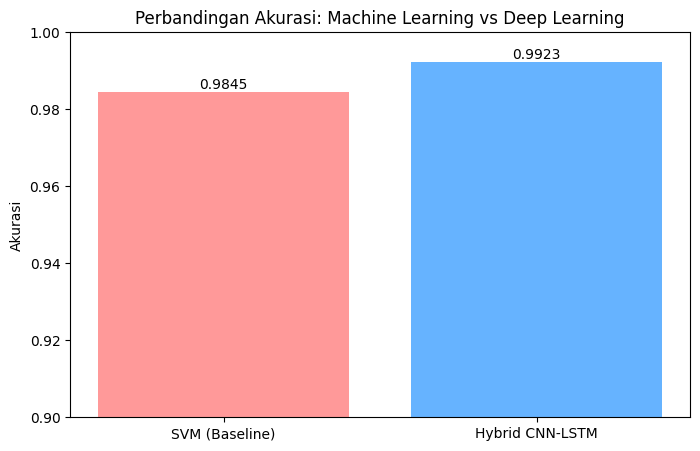

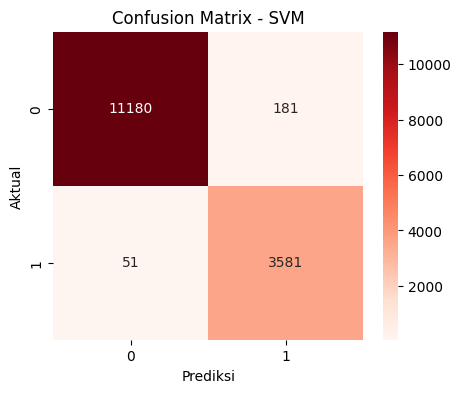

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("🚀 MEMULAI TRAINING BASELINE: SVM...")

# 1. PERSIAPAN DATA (FLATTENING)
# Ubah dimensi dari (Samples, 50, 5) menjadi (Samples, 250)
num_pixels = X_train.shape[1] * X_train.shape[2]

X_train_flat = X_train.reshape(X_train.shape[0], num_pixels)
X_test_flat = X_test.reshape(X_test.shape[0], num_pixels)

print(f"   Dimensi Input SVM: {X_train_flat.shape}")

# 2. TRAINING MODEL SVM
# PENTING: Kita batasi training pada 20.000 data pertama saja agar tidak hang/lama.
# SVM memiliki kompleksitas O(n^2), sangat lambat jika data > 50.000.
TRAIN_LIMIT = 20000

print(f"   Melatih SVM pada {TRAIN_LIMIT} sampel data (Subset)...")
svm_model = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm_model.fit(X_train_flat[:TRAIN_LIMIT], y_train[:TRAIN_LIMIT])

print("✅ Training SVM Selesai!")

# 3. EVALUASI SVM
print("⏳ Sedang memprediksi data test...")
y_pred_svm = svm_model.predict(X_test_flat)

print("\n--- HASIL EVALUASI SVM (BASELINE) ---")
print(classification_report(y_test, y_pred_svm))

# 4. PERBANDINGAN: CNN-LSTM vs SVM
# Ambil akurasi CNN-LSTM dari model sebelumnya
# (Pastikan variabel 'history_base' atau 'model_base' sudah dijalankan)
try:
    y_pred_cnn = (model_base.predict(X_test) > 0.5).astype(int)
    acc_cnn = accuracy_score(y_test, y_pred_cnn)
except:
    acc_cnn = 0.0 # Ganti manual jika error

acc_svm = accuracy_score(y_test, y_pred_svm)

print(f"Akurasi CNN-LSTM : {acc_cnn:.4f}")
print(f"Akurasi SVM      : {acc_svm:.4f}")

# Plot Bar Chart Perbandingan
models = ['SVM (Baseline)', 'Hybrid CNN-LSTM']
accuracies = [acc_svm, acc_cnn]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['#ff9999','#66b3ff'])
plt.ylim(0.90, 1.0) # Zoom in skala
plt.title('Perbandingan Akurasi: Machine Learning vs Deep Learning')
plt.ylabel('Akurasi')

# Label Angka
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.4f}", ha='center', va='bottom')

plt.show()

# Confusion Matrix SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix - SVM')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()